In [1]:
GPT_CONFIG_124M = {
"vocab_size": 50257, # Vocabulary size
"context_length": 1024, # Context length
"emb_dim": 768, # Embedding dimension
"n_heads": 12, # Number of attention heads
"n_layers": 12, # Number of layers
"drop_rate": 0.1, # Dropout rate
"qkv_bias": False # Query-Key-Value bias
}

In [2]:
import torch
import torch.nn as nn

In [3]:
class DummyGPTModel(nn.Module):
   def __init__(self, cfg):
      super().__init__()
      self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
      self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
      self.drop_emb = nn.Dropout(cfg["drop_rate"])
      self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
      self.final_norm = DummyLayerNorm(cfg["emb_dim"])
      self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
   def forward(self, in_idx):
      batch_size, seq_len = in_idx.shape
      tok_embeds = self.tok_emb(in_idx)
      pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
      x = tok_embeds + pos_embeds
      x = self.drop_emb(x)
      x = self.trf_blocks(x)
      x = self.final_norm(x)
      logits = self.out_head(x)
      return logits

In [4]:
class DummyTransformerBlock(nn.Module):
   def __init__(self, cfg):
      super().__init__()
   def forward(self, x):
      return x

In [5]:
class DummyLayerNorm(nn.Module):
   def __init__(self, normalized_shape, eps=1e-5):
      super().__init__()
   def forward(self, x):
      return x

In [6]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [7]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


In [8]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [9]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [10]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [11]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [12]:
class LayerNorm(nn.Module):
   def __init__(self, emb_dim):
      super().__init__()
      self.eps = 1e-5
      self.scale = nn.Parameter(torch.ones(emb_dim))
      self.shift = nn.Parameter(torch.zeros(emb_dim))
   def forward(self, x):
      mean = x.mean(dim=-1, keepdim=True)
      var = x.var(dim=-1, keepdim=True, unbiased=False)
      norm_x = (x - mean) / torch.sqrt(var + self.eps)
      return self.scale * norm_x + self.shift

In [13]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [14]:
class GELU(nn.Module):
   def __init__(self):
      super().__init__()
   def forward(self, x):
      return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) *(x + 0.044715 * torch.pow(x, 3))))

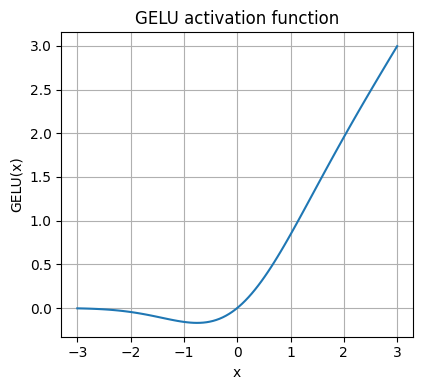

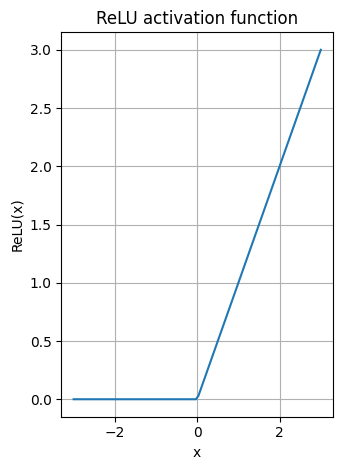

In [15]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 4))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
   plt.subplot(1, 2, i)
   plt.plot(x, y)
   plt.title(f"{label} activation function")
   plt.xlabel("x")
   plt.ylabel(f"{label}(x)")
   plt.grid(True)
   plt.tight_layout()
   plt.show()

In [16]:
class FeedForward(nn.Module):
   def __init__(self, cfg):
      super().__init__()
      self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), GELU(), nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),)
   def forward(self, x):
      return self.layers(x)

In [17]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [18]:
class ExampleDeepNeuralNetwork(nn.Module):
   def __init__(self, layer_sizes, use_shortcut):
      super().__init__()
      self.use_shortcut = use_shortcut
      self.layers = nn.ModuleList([nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
                                   nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),GELU()),
                                   nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),GELU()),
                                   nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),GELU()),
                                   nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),GELU())])

   def forward(self, x):
      for layer in self.layers:
         layer_output = layer(x)
         if self.use_shortcut and x.shape == layer_output.shape:
            x = x + layer_output
         else:
            x = layer_output
      return x

In [19]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [20]:
def print_gradients(model, x):
   output = model(x)
   target = torch.tensor([[0.]])
   loss = nn.MSELoss()
   loss = loss(output, target)
   loss.backward()
   for name, param in model.named_parameters():
      if 'weight' in name:
         print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [21]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


In [22]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


In [23]:
from chapter03 import MultiHeadAttention

class TransformerBlock(nn.Module):
   def __init__(self, cfg):
      super().__init__()
      self.att = MultiHeadAttention(d_in=cfg["emb_dim"],d_out=cfg["emb_dim"],context_length=cfg["context_length"],
                                    num_heads=cfg["n_heads"],dropout=cfg["drop_rate"],qkv_bias=cfg["qkv_bias"])
      self.ff = FeedForward(cfg)
      self.norm1 = LayerNorm(cfg["emb_dim"])
      self.norm2 = LayerNorm(cfg["emb_dim"])
      self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

   def forward(self, x):
      shortcut = x
       
      x = self.norm1(x)
      x = self.att(x)
      x = self.drop_shortcut(x)
      x = x + shortcut
       
      shortcut = x
       
      x = self.norm2(x)
      x = self.ff(x)
      x = self.drop_shortcut(x)
      x = x + shortcut
      return x

In [24]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [25]:
class GPTModel(nn.Module):
   def __init__(self, cfg):
      super().__init__()
      self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
      self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
      self.drop_emb = nn.Dropout(cfg["drop_rate"])
      self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
      self.final_norm = LayerNorm(cfg["emb_dim"])
      self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

   def forward(self, in_idx):
      batch_size, seq_len = in_idx.shape
      tok_embeds = self.tok_emb(in_idx)
      pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
      x = tok_embeds + pos_embeds
      x = self.drop_emb(x)
      x = self.trf_blocks(x)
      x = self.final_norm(x)
      logits = self.out_head(x)
      return logits

In [26]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [27]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [28]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [29]:
total_params_gpt2 = (total_params - sum(p.numel()for p in model.out_head.parameters()))
print(f"Number of trainable parameters "
f"considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [30]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [31]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
   for _ in range(max_new_tokens):
      idx_cond = idx[:, -context_size:]
      with torch.no_grad():
        logits = model(idx_cond)
      logits = logits[:, -1, :]
      probas = torch.softmax(logits, dim=-1)
      idx_next = torch.argmax(probas, dim=-1, keepdim=True)
      idx = torch.cat((idx, idx_next), dim=1)
   return idx

In [32]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [33]:
model.eval()
out = generate_text_simple(model = model, idx=encoded_tensor, max_new_tokens=6, context_size=GPT_CONFIG_124M["context_length"])
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [34]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue
